### Librairies import

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm

from scipy import ndimage as ndi
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
from skimage.filters import rank
from skimage.morphology import disk
import sklearn.metrics

### Datasets import

In [2]:
from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df

In [3]:
X_train, X_test, y_train = get_data()

#### X_train collected ####
#### X_test collected ####
#### y_train collected ####


### Data display

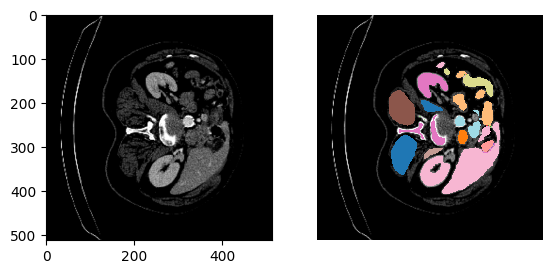

In [4]:
plot_slice_seg(X_train[0], y_train.iloc[0].values.reshape((512,512)))

### Felzenszwalb Model

In [88]:
def felzenszwalb_one_sample(data_slice, scale=100, sigma=0.2, min_size=2000):
    label_predicted = felzenszwalb(data_slice, scale=scale, sigma=sigma, min_size=min_size)
    return label_predicted

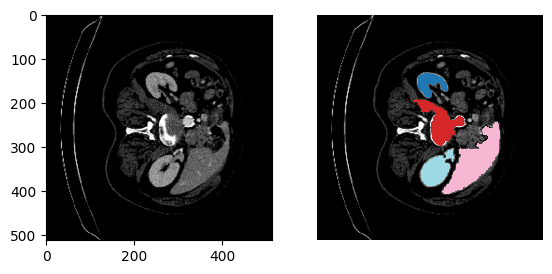

In [89]:
plot_slice_seg(X_train[0], felzenszwalb_one_sample(X_train[0]))

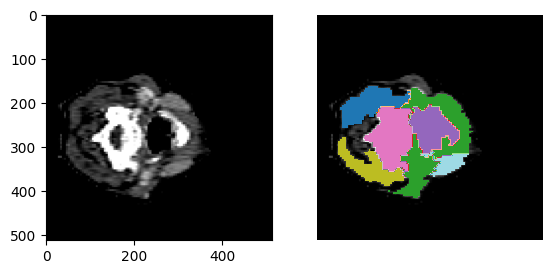

In [7]:
plot_slice_seg(X_train[10], felzenszwalb_one_sample(X_train[10]))

### Baselin Performances 

In [80]:
# Compute the baseline on a whole dataset
def compute_felzenszwalb(dataset: np.array, scale=10, sigma=0.2, min_size=2000, verbosity=True):
    labels_predicted_list = []
    s = 0
    for index in range(np.shape(dataset)[0]):
        data_slice = dataset[index]
        label_predicted = felzenszwalb_one_sample(data_slice, scale=scale, sigma=sigma, min_size=min_size)
        labels_predicted_list.append(label_predicted)
        if verbosity:
            if s%20 == 0:
                print(f"Image {s}/200 processed")
        s =  s+1
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [9]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = X_train[:200]
labels_val = y_train.iloc[:200]

In [21]:
# Compute baseline on a few train data
labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val)

Image 0/200 processed
Image 20/200 processed
Image 40/200 processed
Image 60/200 processed
Image 80/200 processed
Image 100/200 processed
Image 120/200 processed
Image 140/200 processed
Image 160/200 processed
Image 180/200 processed


Let's try to get the optimal params for the model

In [13]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_felzenszwalb.sample(200))

0.08929598532122313

In [92]:
def grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size):
    nb_possibilities = len(scale_range)*len(sigma_range)*len(min_size_range)
    print(f"Grid search will test {nb_possibilities} combinations")
    s = 0
    scores_dict = {}
    data = X_train[:data_size]
    labels = y_train.iloc[:data_size]
    for scale in scale_range:
        for sigma in sigma_range:
            for min_size in min_size_range:
                prediction = compute_felzenszwalb(data, scale, sigma, min_size, verbosity=False)
                score = rand_index_dataset(labels, prediction.sample(data_size))
                scores_dict[score] = {'scale_param':scale, 'sigma_param':sigma, 'min_size_param':min_size}
                s = s+1
                if s%100 == 0:
                    print(f"Combination {s}/{nb_possibilities}")
    best_params = scores_dict[max(scores_dict.keys())]
    return best_params

In [93]:
scale_range = np.arange(1, 100, 10)
sigma_range = np.arange(0.1, 1, 0.1)
min_size_range = np.arange(100, 2000, 100)
grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size)

Grid search will test 1710 combinations
Combination 100/1710
Combination 200/1710
Combination 300/1710
Combination 400/1710
Combination 500/1710
Combination 600/1710
Combination 700/1710
Combination 800/1710
Combination 900/1710
Combination 1000/1710
Combination 1100/1710
Combination 1200/1710
Combination 1300/1710
Combination 1400/1710
Combination 1500/1710
Combination 1600/1710
Combination 1700/1710


{'scale_param': 51, 'sigma_param': 0.9, 'min_size_param': 900}

Let's test with theses params

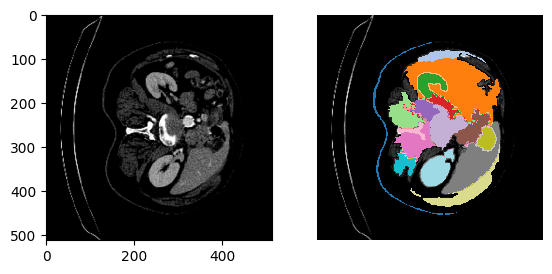

In [94]:
plot_slice_seg(X_train[0], felzenszwalb_one_sample(X_train[0], scale=51, sigma=0.9, min_size=900))

In [96]:
gs_labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val, scale=51, sigma=0.9, min_size=900)
rand_index_dataset(labels_val, gs_labels_val_predicted_felzenszwalb.sample(200))

Image 0/200 processed
Image 20/200 processed
Image 40/200 processed
Image 60/200 processed
Image 80/200 processed
Image 100/200 processed
Image 120/200 processed
Image 140/200 processed
Image 160/200 processed
Image 180/200 processed


0.22738008466147341